In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np

from store_data import DataStore
from utilities import get_building_id, get_location_id, get_lat_lng, starting_date, time_delta, year, get_date, timestamp_to_string, epoch_to_date

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

In [2]:
raw_data_path = 'data/'

In [8]:
for dirpath, dirnames, filenames in os.walk(raw_data_path):
    print(dirpath)

data/


In [9]:
energystats = pd.DataFrame()
exclude_files = ['USA_AK_FAIRBANKS_temperature_usage.csv', 'USA_CA_LOS_ANGELES_temperature_usage.csv',
                 'USA_IL_CHICAGO-OHARE_temperature_usage.csv', 'USA_MN_MINNEAPOLIS_temperature_usage.csv', 
                 'USA_TX_HOUSTON_temperature_usage.csv', 'USA_WA_SEATTLE_temperature_usage.csv',
                 '.DS_Store', 'Holidays.csv', 'energystats.csv', 'dataset.csv', 'All_locations_temperature_usage.csv']
for file_ in filenames:
    if file_ in exclude_files:
        continue
    df = pd.read_csv(dirpath+file_)
    building_type = file_[:file_.index("2004")]
    location = file_[file_.index("USA_"):file_.index(".csv")]
    df['building_type'] = building_type
    df['location'] = location
    energystats = pd.concat((df, energystats), axis=0)

In [10]:
energystats.count()

Cooling:Electricity [kW](Hourly)              840960
Date/Time                                     840960
Electricity:Facility [kW](Hourly)             840960
Electricity:Facility [kW](Monthly)                 0
Fans:Electricity [kW](Hourly)                 840960
Gas:Facility [kW](Hourly)                     840960
Gas:Facility [kW](Monthly)                         0
Heating:Electricity [kW](Hourly)              840960
Heating:Gas [kW](Hourly)                      840960
InteriorEquipment:Electricity [kW](Hourly)    840960
InteriorEquipment:Gas [kW](Hourly)            473040
InteriorLights:Electricity [kW](Hourly)       840960
Water Heater:WaterSystems:Gas [kW](Hourly)    683280
building_type                                 840960
location                                      840960
dtype: int64

In [11]:
energystats.head(5)

,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),building_type,location
0,0.0,01/01 01:00:00,22.200377,NaN,6.784553,198.184686,NaN,0.0,198.184686,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS
1,0.0,01/01 02:00:00,20.673749,NaN,5.257925,156.818509,NaN,0.0,156.818509,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS
2,0.0,01/01 03:00:00,22.051864,NaN,6.636040,179.738632,NaN,0.0,179.738632,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS
3,0.0,01/01 04:00:00,20.450578,NaN,5.034754,144.452862,NaN,0.0,144.452862,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS
4,0.0,01/01 05:00:00,21.914217,NaN,6.498393,172.954875,NaN,0.0,172.954875,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS


In [12]:
energystats.groupby('location').count()

,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),building_type
location,,,,,,,,,,,,,,
USA_AK_FAIRBANKS,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_CA_LOS_ANGELES,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_IL_CHICAGO-OHARE,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_MN_MINNEAPOLIS,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_TX_HOUSTON,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_WA_SEATTLE,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160


In [13]:
energystats['location_id'] = energystats['location'].apply(get_location_id)
energystats['building_id'] = energystats['building_type'].apply(get_building_id)

In [14]:
energystats['Date'] = energystats['Date/Time'].apply(get_date)
energystats.Date = energystats.Date.astype(str)
energystats.head(5)

,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),building_type,location,location_id,building_id,Date
0,0.0,01/01 01:00:00,22.200377,NaN,6.784553,198.184686,NaN,0.0,198.184686,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01
1,0.0,01/01 02:00:00,20.673749,NaN,5.257925,156.818509,NaN,0.0,156.818509,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01
2,0.0,01/01 03:00:00,22.051864,NaN,6.636040,179.738632,NaN,0.0,179.738632,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01
3,0.0,01/01 04:00:00,20.450578,NaN,5.034754,144.452862,NaN,0.0,144.452862,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01
4,0.0,01/01 05:00:00,21.914217,NaN,6.498393,172.954875,NaN,0.0,172.954875,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01


In [15]:
holidays = pd.read_csv("data/Holidays.csv")
energystats_holidays = pd.merge(energystats, holidays,
                                on='Date', how='outer')

energystats_holidays.count()

Cooling:Electricity [kW](Hourly)              840960
Date/Time                                     840960
Electricity:Facility [kW](Hourly)             840960
Electricity:Facility [kW](Monthly)                 0
Fans:Electricity [kW](Hourly)                 840960
Gas:Facility [kW](Hourly)                     840960
Gas:Facility [kW](Monthly)                         0
Heating:Electricity [kW](Hourly)              840960
Heating:Gas [kW](Hourly)                      840960
InteriorEquipment:Electricity [kW](Hourly)    840960
InteriorEquipment:Gas [kW](Hourly)            473040
InteriorLights:Electricity [kW](Hourly)       840960
Water Heater:WaterSystems:Gas [kW](Hourly)    683280
building_type                                 840960
location                                      840960
location_id                                   840960
building_id                                   840960
Date                                          840960
Holiday                                       

In [10]:
"""
data_store = DataStore('35.227.50.121')
data_store.connect_to_database()
data_store.store_data(energystats)
"""

"\ndata_store = DataStore('35.227.50.121')\ndata_store.connect_to_database()\ndata_store.store_data(energystats)\n"

In [16]:
temperaturestats = pd.DataFrame()
locations = ['USA_AK_FAIRBANKS', 'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS', 'USA_TX_HOUSTON', 'USA_WA_SEATTLE']
for location in locations:
    loc_temp_usage = pd.read_csv(dirpath+location+'_temperature_usage.csv')
    loc_temp_usage['Date'] = loc_temp_usage['time'].apply(epoch_to_date)
    loc_temp_usage['location'] = location
    temperaturestats = pd.concat((loc_temp_usage, temperaturestats), axis=0)
temperaturestats.drop(columns=['Unnamed: 0'], inplace=True)
temperaturestats.to_csv('data/All_locations_temperature_usage.csv')

In [17]:
temperaturestats.groupby('location').count()

,time,sunriseTime,sunsetTime,temperatureHigh,dewPoint,humidity,windSpeed,cloudCover,Date
location,,,,,,,,,
USA_AK_FAIRBANKS,366,366,366,366,366,366,366,366,366
USA_CA_LOS_ANGELES,366,366,366,366,366,366,366,366,366
USA_IL_CHICAGO-OHARE,366,366,366,366,366,366,366,366,366
USA_MN_MINNEAPOLIS,366,366,366,366,366,366,366,366,366
USA_TX_HOUSTON,366,366,366,366,366,366,366,366,366
USA_WA_SEATTLE,366,366,366,366,366,366,366,366,366


In [18]:
temperaturestats.head(5)

,time,sunriseTime,sunsetTime,temperatureHigh,dewPoint,humidity,windSpeed,cloudCover,Date,location
0,1072944000,1072972728,1073003348,38.67,31.26,0.85,1.43,0.86,01/01,USA_WA_SEATTLE
1,1073030400,1073059126,1073089805,38.30,33.51,0.91,1.47,0.96,01/02,USA_WA_SEATTLE
2,1073116800,1073145521,1073176264,33.13,23.97,0.77,3.97,1.00,01/03,USA_WA_SEATTLE
3,1073203200,1073231913,1073262726,27.53,12.03,0.59,4.39,0.38,01/04,USA_WA_SEATTLE
4,1073289600,1073318303,1073349189,28.41,6.93,0.47,3.02,0.56,01/05,USA_WA_SEATTLE


In [19]:
temperature_usage = pd.read_csv("data/All_locations_temperature_usage.csv")
dataset = pd.merge(energystats_holidays, temperature_usage,
                   on=['Date','location'], how='inner')

In [20]:
dataset = dataset.drop(columns=['Unnamed: 0'])

In [21]:
dataset.count()

Cooling:Electricity [kW](Hourly)              840960
Date/Time                                     840960
Electricity:Facility [kW](Hourly)             840960
Electricity:Facility [kW](Monthly)                 0
Fans:Electricity [kW](Hourly)                 840960
Gas:Facility [kW](Hourly)                     840960
Gas:Facility [kW](Monthly)                         0
Heating:Electricity [kW](Hourly)              840960
Heating:Gas [kW](Hourly)                      840960
InteriorEquipment:Electricity [kW](Hourly)    840960
InteriorEquipment:Gas [kW](Hourly)            473040
InteriorLights:Electricity [kW](Hourly)       840960
Water Heater:WaterSystems:Gas [kW](Hourly)    683280
building_type                                 840960
location                                      840960
location_id                                   840960
building_id                                   840960
Date                                          840960
Holiday                                       

In [103]:
dataset.to_csv('data/dataset.csv')

In [22]:
dataset.head(5)

,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),...,Holiday,Holiday_code,time,sunriseTime,sunsetTime,temperatureHigh,dewPoint,humidity,windSpeed,cloudCover
0,0.0,01/01 01:00:00,22.200377,NaN,6.784553,198.184686,NaN,0.0,198.184686,1.0116,...,New Years Day,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19
1,0.0,01/01 02:00:00,20.673749,NaN,5.257925,156.818509,NaN,0.0,156.818509,1.0116,...,New Years Day,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19
2,0.0,01/01 03:00:00,22.051864,NaN,6.636040,179.738632,NaN,0.0,179.738632,1.0116,...,New Years Day,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19
3,0.0,01/01 04:00:00,20.450578,NaN,5.034754,144.452862,NaN,0.0,144.452862,1.0116,...,New Years Day,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19
4,0.0,01/01 05:00:00,21.914217,NaN,6.498393,172.954875,NaN,0.0,172.954875,1.0116,...,New Years Day,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19


### Predict Energy consumption

In [105]:
dataset = pd.read_csv('data/dataset.csv')

In [23]:
dataset["Electricity:Facility [kW](Monthly)"].fillna(0, inplace=True)
dataset["Gas:Facility [kW](Monthly)"].fillna(0, inplace=True)
dataset["InteriorEquipment:Gas [kW](Hourly)"].fillna(0, inplace=True)
dataset["Water Heater:WaterSystems:Gas [kW](Hourly)"].fillna(0, inplace=True)
dataset["Holiday_code"].fillna(0, inplace=True)
dataset.isna().sum()

Cooling:Electricity [kW](Hourly)                   0
Date/Time                                          0
Electricity:Facility [kW](Hourly)                  0
Electricity:Facility [kW](Monthly)                 0
Fans:Electricity [kW](Hourly)                      0
Gas:Facility [kW](Hourly)                          0
Gas:Facility [kW](Monthly)                         0
Heating:Electricity [kW](Hourly)                   0
Heating:Gas [kW](Hourly)                           0
InteriorEquipment:Electricity [kW](Hourly)         0
InteriorEquipment:Gas [kW](Hourly)                 0
InteriorLights:Electricity [kW](Hourly)            0
Water Heater:WaterSystems:Gas [kW](Hourly)         0
building_type                                      0
location                                           0
location_id                                        0
building_id                                        0
Date                                               0
Holiday                                       

In [24]:
dataset.columns

Index(['Cooling:Electricity [kW](Hourly)', 'Date/Time',
       'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Monthly)', 'Fans:Electricity [kW](Hourly)',
       'Gas:Facility [kW](Hourly)', 'Gas:Facility [kW](Monthly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'Holiday',
       'Holiday_code', 'time', 'sunriseTime', 'sunsetTime', 'temperatureHigh',
       'dewPoint', 'humidity', 'windSpeed', 'cloudCover'],
      dtype='object')

In [25]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)', 'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)', 'InteriorEquipment:Gas [kW](Hourly)', 'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'location_id', 'building_id', 'Holiday_code',
                           'time', 'sunriseTime', 'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover'
                         ]]

In [26]:
dataset_numeric.head(5)

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),location_id,building_id,Holiday_code,time,sunriseTime,sunsetTime,temperatureHigh,dewPoint,humidity,windSpeed,cloudCover
0,0.0,22.200377,6.784553,198.184686,0.0,1.0116,0.0,5.481225,0.0,1,16,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19
1,0.0,20.673749,5.257925,156.818509,0.0,1.0116,0.0,5.481225,0.0,1,16,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19
2,0.0,22.051864,6.636040,179.738632,0.0,1.0116,0.0,5.481225,0.0,1,16,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19
3,0.0,20.450578,5.034754,144.452862,0.0,1.0116,0.0,5.481225,0.0,1,16,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19
4,0.0,21.914217,6.498393,172.954875,0.0,1.0116,0.0,5.481225,0.0,1,16,1.0,1072947600,1072986945,1073001320,-3.79,-18.61,0.68,0.04,0.19


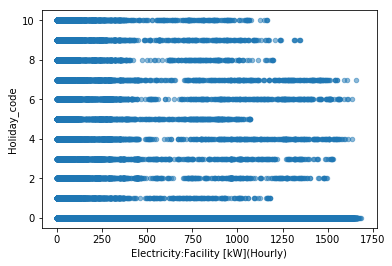

In [37]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="Holiday_code", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

In [36]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)             1.000000
InteriorEquipment:Electricity [kW](Hourly)    0.891002
Cooling:Electricity [kW](Hourly)              0.863239
Fans:Electricity [kW](Hourly)                 0.827725
InteriorLights:Electricity [kW](Hourly)       0.823771
Gas:Facility [kW](Hourly)                     0.437128
InteriorEquipment:Gas [kW](Hourly)            0.419681
Water Heater:WaterSystems:Gas [kW](Hourly)    0.157099
dewPoint                                      0.064267
temperatureHigh                               0.063716
location_id                                   0.023742
sunsetTime                                    0.008206
time                                          0.008184
sunriseTime                                   0.008173
windSpeed                                     0.003483
humidity                                     -0.001122
Holiday_code                                 -0.010689
cloudCover                                   -0.022154
Heating:El

In [44]:
dataset_features = dataset_numeric[['Cooling:Electricity [kW](Hourly)',
                                    'Fans:Electricity [kW](Hourly)', 
                                    'Gas:Facility [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
                                    'InteriorEquipment:Electricity [kW](Hourly)', 'InteriorEquipment:Gas [kW](Hourly)', 'InteriorLights:Electricity [kW](Hourly)',
                                    'Water Heater:WaterSystems:Gas [kW](Hourly)', 'location_id', 'building_id', 'Holiday_code',
                                    'time', 'sunriseTime', 'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                                    'cloudCover']]
dataset_labels = dataset_numeric[['Electricity:Facility [kW](Hourly)']]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)

In [42]:
model = LinearRegression()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Linear Regression model
Mean Squared Error: 1282.002
Coefficient of Determination: 0.987


In [43]:
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Ridge model
Mean Squared Error: 1282.002
Coefficient of Determination: 0.987


In [33]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Random Forest model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Random Forest model
Mean squared error = 62.187
R2 score = 0.999
